In [157]:
%load_ext autoreload
%autoreload 2

In [158]:
import os
import json
import pandas as pd

import analysis_lib

In [2]:
files = os.listdir('logs')
log_files = [ f for f in files if f != ".gitignore" ]
log_files[:2]

['ReFAct-ab208055-1c82-4afb-a7ed-96356bfb9c9b.json',
 'ReFAct-f4de6a68-fc6c-48be-bba7-98ec9bc21217.json']

# Analyse the logs

The ReFAct agent comes with a number of configuration settings:

In [3]:
log_file = json.load(open('logs/' + log_files[0]))
config_settings = list(log_file['agent_settings'].keys())
config_settings

['consider_cyclomatic_complexity',
 'make_incremental_changes',
 'use_refactoring_tricks',
 'get_buddy_feedback',
 'use_previous_history',
 'make_plan',
 'dynamic_plan',
 'modify_specific_method',
 'clear_error_after_n',
 'clip_context_window']

As a first experiment, the agent was run on a number of sample projects:

In [4]:
SAMPLE_PROJECTS_DIR = 'samples'
projects = os.listdir(SAMPLE_PROJECTS_DIR)
projects

['js_gilded_rose',
 'java_gilded_rose',
 'js_json_object',
 'java_tabula',
 'py_yahtzee',
 'java_tennis',
 'java_yahtzee',
 'py_tennis',
 'js_trivia']

Each config setting was enabled exactly once, with all other config settings disabled. This was executed for each sample project, resulting in the following number of agent logs:

In [5]:
len(projects) * len(config_settings) + len(projects)

99

In [6]:
# First, let's load all the logs. Result is a list of dictionaries
log_jsons = []
for log_file in log_files:
    with open(f"logs/{log_file}") as f:
        log_jsons.append(json.load(f))

# Create a dataframe from the list of dictionaries
df = pd.DataFrame(log_jsons)

# the 'execution' column is again a list of dictionaries,
# so we need to explode
df = df.explode("execution")
print("Rows, Cols:", df.shape)
df.head()

Rows, Cols: (3630, 4)


,agent_settings,execution,project,llm
0,"{'consider_cyclomatic_complexity': False, 'mak...",\n You are a professional software develope...,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...","{'thought': 'First, I need to get an overview ...",/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...","{'tool': 'browse_files', 'result': 'Files: ten...",/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...",{'thought': 'I should start by examining the m...,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...","{'tool': 'open_file', 'result': '# -*- coding:...",/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o


In [7]:
# drop all rows where the execution doesn't parse to a dict

df = df[df["execution"].apply(lambda x: isinstance(x, dict))]
print("Rows, Cols:", df.shape)

# drop all rows where "tool" key is not present in the execution dictionary
df = df[df["execution"].apply(lambda x: "tool" in x)]

# we normalize the "agent_settings" column as well as the "execution" column,
# which both contain dictionaries

df_as_list = df.to_dict(orient="records")
df = pd.json_normalize(df_as_list)
print("Rows, Cols:", df.shape)

df.head(3)

Rows, Cols: (3484, 4)
Rows, Cols: (1677, 15)


,project,llm,agent_settings.consider_cyclomatic_complexity,agent_settings.make_incremental_changes,agent_settings.use_refactoring_tricks,agent_settings.get_buddy_feedback,agent_settings.use_previous_history,agent_settings.make_plan,agent_settings.dynamic_plan,agent_settings.modify_specific_method,agent_settings.clear_error_after_n,agent_settings.clip_context_window,execution.tool,execution.result,execution.error
0,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,True,browse_files,"Files: tennis.py, test_tennis.py, test_tennis_...",NaN
1,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,True,open_file,# -*- coding: utf-8 -*-\n\nclass TennisGameDef...,NaN
2,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,True,open_file,# -*- coding: utf-8 -*-\n\nimport pytest\nfrom...,NaN


Now that we've arranged our data, it's time to analyze it. Let's start with the number of commits as a first metric.

In [8]:
# select all columns where the execution.tool is "commit_changes"
df = df[df["execution.tool"] == "commit_changes"]
df[["execution.tool", "project"]].describe()

,execution.tool,project
count,215,215
unique,1,9
top,commit_changes,/Users/I539028/Desktop/Seminar/refactoring-lab...
freq,215,37


In [9]:
# finde the rows where all columns that start with "agent_settings" are set to False
df_all_settings_false = df[~df.filter(like="agent_settings").any(axis=1)]
df_all_settings_false.head(3)

,project,llm,agent_settings.consider_cyclomatic_complexity,agent_settings.make_incremental_changes,agent_settings.use_refactoring_tricks,agent_settings.get_buddy_feedback,agent_settings.use_previous_history,agent_settings.make_plan,agent_settings.dynamic_plan,agent_settings.modify_specific_method,agent_settings.clear_error_after_n,agent_settings.clip_context_window,execution.tool,execution.result,execution.error
42,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,False,commit_changes,Changes committed.,NaN
248,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,False,commit_changes,Changes committed.,NaN
370,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,False,commit_changes,No changes to commit for file src/main/java/Ya...,NaN


In [10]:
# get the number of rows where all columns that start with "agent_settings" are set to False
num_commits_all_disabled = len(df_all_settings_false)
num_commits_all_disabled

18

In [11]:
# lambda function to transform the snake_case to Upper Case With Spaces
snake_to_upper = lambda x: x.replace("_", " ").title()

In [12]:
# create a new df, with a row for each agent setting and the number of commits
df_commit_counts = pd.DataFrame()
for agent_setting in config_settings:
    df_commit_counts[agent_setting] = df[f"agent_settings.{agent_setting}"].value_counts().values
df_commit_counts

# apply the snake_to_upper function to the column names
df_commit_counts.columns = df_commit_counts.columns.map(snake_to_upper)

# transpose the dataframe, so that the agent settings are the columns
df_commit_counts = df_commit_counts.T

# drop the first column, since the second column is the number of commits
df_commit_counts = df_commit_counts.drop(df_commit_counts.columns[0], axis=1)
df_commit_counts.columns = ["Number of tested commits"]

# append a row with the number of commits where all agent settings are disabled
df_commit_counts.loc["No Settings Enabled"] = [num_commits_all_disabled]

# sort ascending
df_commit_counts = df_commit_counts.sort_values(by="Number of tested commits", ascending=True)
df_commit_counts

,Number of tested commits
Consider Cyclomatic Complexity,12
Make Incremental Changes,14
Get Buddy Feedback,15
Use Previous History,17
No Settings Enabled,18
Clip Context Window,19
Clear Error After N,20
Dynamic Plan,23
Use Refactoring Tricks,26
Modify Specific Method,33


In [13]:
# get the idx of "No Settings Enabled"
idx = df_commit_counts.index.get_loc("No Settings Enabled")
idx

4

Below is the first set of evaluation, showing the (individually) enabled agent settings and their effect on the number of successful commits.

<Axes: >

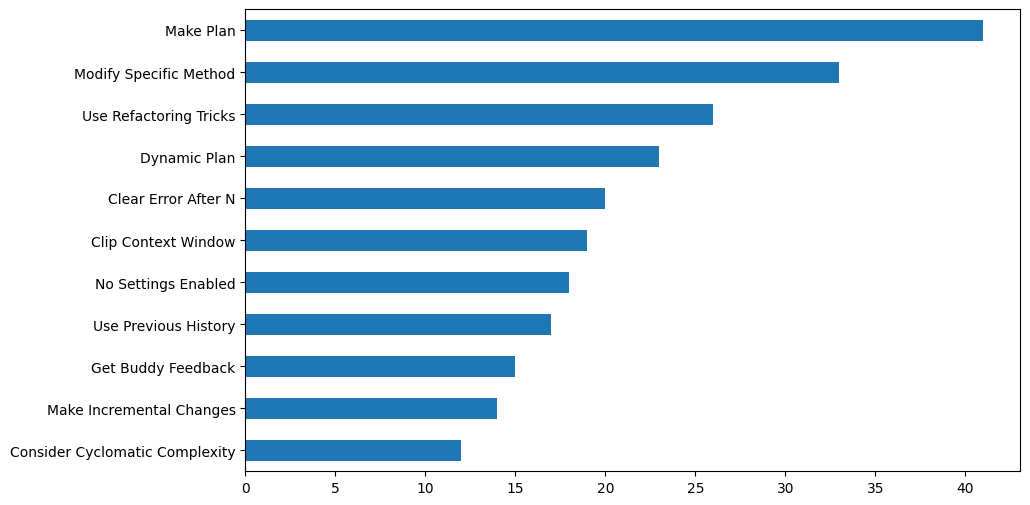

In [14]:
# display as a histogram
df_commit_counts.plot(kind="barh", legend=False, figsize=(10, 6))

## Next, let's try to find out some information about the commits that were made

In [15]:
all_commit_messages = []

for log_json in log_jsons:
    if "execution" in log_json:
        for execution in log_json["execution"]:
            if not isinstance(execution, dict):
                continue
            if "action" in execution and execution["action"] == "commit_changes":
                all_commit_messages.append(execution)

df = pd.json_normalize(all_commit_messages)

# let's get the columns "thought", "action", "tools_input.commit_message" (rename to "commit_message")
df = df[["thought", "action", "tools_input.commit_message"]]
df = df.rename(columns={"tools_input.commit_message": "commit_message"})

# apply the snake_to_upper function to the column names
df.columns = df.columns.map(snake_to_upper)

print("Number of commits:", len(df))
df.head()

Number of commits: 216


,Thought,Action,Commit Message
0,The refactoring of TennisGameDefactored1 was s...,commit_changes,Refactored TennisGameDefactored1 class to impr...
1,The refactoring was successful and all tests h...,commit_changes,Refactored tennis.py to use only the first imp...
2,The tests have passed successfully. I will now...,commit_changes,Refactor: Rename variables and methods in Tenn...
3,The refactoring of the `won_point` method was ...,commit_changes,Refactored won_point method to include a check...
4,"The tests have passed successfully, indicating...",commit_changes,Refactored update_quality function by extracti...


In [16]:
# get the unique commit messages
unique_commit_messages = df["Commit Message"].unique()
len(unique_commit_messages)

201

In [17]:
# display the commit messages that are NOT unique
df["Commit Message"].value_counts().head(10)


Commit Message
Refactored TennisGameDefactored1 class to improve readability and maintainability.                                                            5
Refactored TennisGameDefactored2 class to improve readability and maintainability.                                                            3
Refactored forEach function to use modern JavaScript features like for...of and Object.entries for better readability and maintainability.    3
Refactored currentCategory function to use a map for better readability and maintainability.                                                  3
Refactored GildedRose class to use the Strategy pattern for updating item quality.                                                            2
Refactored wonPoint method in TennisGame1 to use equals for string comparison.                                                                2
Refactor: Rename method 'feq' to 'isApproximatelyEqual' for better clarity and update all references.                    

In [18]:
!pip install wordcloud -q

In [19]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# Start with one review:
text = " ".join(df["Commit Message"])

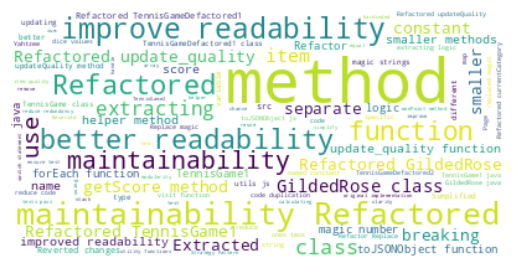

In [21]:
# Create and generate a word cloud image:

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

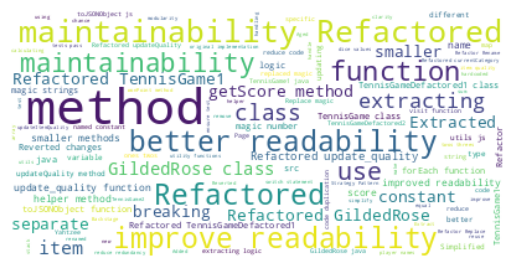

In [22]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [99]:
!pip install sentence-transformers -q
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

import torch
torch.set_num_threads(1)
print("CUDA", torch.cuda.is_available())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


CUDA False


In [163]:
from collections import defaultdict

def embed_and_cluster(corpus, clustering_model, embedding_model):

    embedded_corpus = embedding_model.encode(corpus)
    embedded_corpus.shape

    clustering_model.fit(embedded_corpus)
    cluster_assignment = clustering_model.labels_

    clusters = defaultdict(list)
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        clusters[cluster_id].append(corpus[sentence_id])

    return clusters


In [164]:
from sklearn.cluster import KMeans

# try out KMeans clutering
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)

corpus = df["Commit Message"].values
clustered_sentences = embed_and_cluster(corpus, clustering_model, embedding_model)


In [168]:
[len(c) for c in clustered_sentences.values()]

[70, 76, 29, 27, 14]

In [174]:
from sklearn.cluster import AgglomerativeClustering

# try out agglomerative clutering
clustering_model = AgglomerativeClustering(
    n_clusters=10 # , distance_threshold=3
)
clustered_sentences = embed_and_cluster(corpus, clustering_model, embedding_model)

print([len(c) for c in clustered_sentences.values()])
clusters = [c for c in clustered_sentences.values()]

with open("./clustered_commit_messages.json", "w") as f:
    json.dump({int(k): v for k, v in clustered_sentences.items()}, f, indent=2)

[71, 17, 8, 28, 6, 23, 24, 15, 9, 15]


In [181]:
cluster_labels = [analysis_lib.label_clusters_llm(cluster) for cluster in clusters]
cluster_labels

['Refactoring TennisGame Classes for Readability and Maintainability',
 'Refactoring `update_quality` Function for Improved Readability and Maintainability',
 'Refactoring forEach Function for Readability and Maintainability',
 '**Cluster Label: Code Refactoring for Dice Game Methods**',
 'Refactoring currentCategory Function for Improved Readability and Maintainability',
 'Refactoring and Code Cleanup',
 '**Refactoring and Reverting Changes to `toJSONObject` Function**',
 'Refactoring GildedRose Class for Improved Readability and Maintainability',
 'Reverting Changes to Fix Test Failures',
 'Refactoring GildedRose Class for Improved Readability and Maintainability']

In [206]:
summarized_clusters = analysis_lib.summarize_clusters(cluster_labels)
summarized_clusters

['Code refactoring readability',
 'Refactoring update_quality function',
 'Refactoring forEach function',
 'Code refactoring dice',
 'Refactoring currentCategory function',
 'Refactoring code cleanup',
 'Refactoring toJSONObject function',
 'Refactoring GildedRose class',
 'Reverting test failures',
 'Refactoring GildedRose class']

In [207]:
unique = list(set(summarized_clusters))
print(len(unique))
unique

9


['Refactoring GildedRose class',
 'Refactoring currentCategory function',
 'Refactoring toJSONObject function',
 'Refactoring code cleanup',
 'Refactoring forEach function',
 'Code refactoring readability',
 'Refactoring update_quality function',
 'Reverting test failures',
 'Code refactoring dice']

In [208]:
words = []
for s in unique:
    words.extend(s.split(" "))
pd.Series(words).value_counts(True)[:10]

Refactoring       0.222222
function          0.148148
Code              0.074074
refactoring       0.074074
failures          0.037037
test              0.037037
Reverting         0.037037
update_quality    0.037037
readability       0.037037
forEach           0.037037
Name: proportion, dtype: float64

### Preliminary Observation
It is observed, that often times the clusters are formed based on e.g. the name of the refactored code file / the refactored method. However, what we want, is the clusters to be formed based on the actual refactoring technique / approach / ... that was applied. Hence, we try to remove certain keywords from the sentences (commit messages).

In [180]:
# observation: clusters are driven by specific names of files or functions
updated_corpus = []
for commit_message in df["Commit Message"].values:
    updated_corpus.append(analysis_lib.remove_specific_terms(commit_message))

clustered_sentences_updated = embed_and_cluster(updated_corpus, clustering_model, embedding_model)

with open("./clustered_commit_messages_updated.json", "w") as f:
    json.dump({int(k): v for k, v in clustered_sentences_updated.items()}, f, indent=2)

In [182]:
cluster_labels_updated = [analysis_lib.label_clusters_llm(cluster) for cluster in clustered_sentences_updated.values()]
cluster_labels_updated

['Refactoring for Readability and Maintainability',
 'Refactoring and Code Cleanup',
 'Code Refactoring: Naming Conventions and Constants',
 'Refactoring for Improved Readability and Maintainability',
 'Refactoring `foreach` Function for Readability and Maintainability',
 'Refactoring to Reduce Code Duplication in Dice Calculation Methods',
 'Refactoring for Improved Readability and Maintainability',
 'Cluster Label: "Reverting Changes to Original Implementation to Fix Test Failures"',
 'Refactoring for Improved Readability and Maintainability Using Strategy Pattern',
 'Refactoring and Code Improvement']

In [199]:
summarized_clusters = analysis_lib.summarize_clusters(cluster_labels_updated)
summarized_clusters

['Refactoring readability maintainability',
 'Refactoring code cleanup',
 'Refactoring naming conventions',
 'Refactoring readability maintainability',
 'Refactoring foreach readability',
 'Refactoring reduce duplication',
 'Refactoring readability maintainability',
 'Reverting changes fix',
 'Refactoring readability strategy',
 'Refactoring code improvement']

In [201]:
unique = list(set(summarized_clusters))
print(len(unique))
unique

8


['Refactoring reduce duplication',
 'Refactoring code improvement',
 'Refactoring naming conventions',
 'Refactoring readability maintainability',
 'Reverting changes fix',
 'Refactoring code cleanup',
 'Refactoring readability strategy',
 'Refactoring foreach readability']

In [203]:
words = []
for s in unique:
    words.extend(s.split(" "))
pd.Series(words).value_counts(True)[:10]

Refactoring        0.291667
readability        0.125000
code               0.083333
reduce             0.041667
duplication        0.041667
improvement        0.041667
naming             0.041667
conventions        0.041667
maintainability    0.041667
Reverting          0.041667
Name: proportion, dtype: float64